In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import logging
from torch.utils.data import Dataset, DataLoader
import optuna
import logging

# 로깅 설정
logging.basicConfig(filename='MLP/training.log', level=logging.INFO, format='%(asctime)s %(message)s')

# 데이터셋 로드
data = pd.read_csv('data/train.csv')

# 필요한 열 선택
selected_columns = ['OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind', 'revenue1', 'salescost1', 'sga1', 'salary1',
                    'noi1', 'noe1', 'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
                    'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1',
                    'longLoan1', 'netAsset1', 'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
                    'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2',
                    'receivableL2', 'debt2', 'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
                    'employee1', 'employee2', 'ownerChange']

# 데이터 전처리
# - 결측치 처리
data = data.dropna()  # 결측치가 있는 행 제거 또는 다른 방식으로 처리
# - 범주형 데이터 인코딩
categorical_cols = ['OC', 'sido', 'instkind', 'ownerChange']  # 범주형 열을 선택하여 리스트로 작성
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])
# - 수치형 데이터 표준화
numeric_cols = ['sgg', 'openDate', 'bedCount', 'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1', 'interest1',
                'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
                'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1',
                'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2', 'profit2', 'liquidAsset2',
                'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2', 'receivableL2', 'debt2',
                'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2', 'employee1', 'employee2']

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# 특성(X)과 라벨(y) 분리
X = data.drop('OC', axis=1).values
y = data['OC'].values

# 훈련 데이터와 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1123)

# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor([self.target[idx]])
        return x, y.squeeze()


# 데이터셋과 데이터로더 생성
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.BCEWithLogitsLoss()

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# 학습 함수
def train(model, optimizer, criterion, dataloader, dropout_rate):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(dataloader.dataset)
    return train_loss

# 평가 함수
def evaluate(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
            predicted = (output.squeeze() >= 0.5).float()
            correct += (predicted == batch_y).sum().item()
            total += batch_X.size(0)
    val_loss /= len(dataloader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy

# 모델 저장 함수
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

# Optuna Objective 함수
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    # 모델 초기화
    model = MLP(input_dim).to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # learning rate scheduler 정의
    scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)

    # Early Stopping 기능 구현
    patience = 5
    best_loss = float('inf')
    counter = 0

    # 학습 및 평가
    for epoch in range(num_epochs):
        train_loss = train(model, optimizer, criterion, train_loader, dropout_rate)
        val_loss, val_accuracy = evaluate(model, criterion, val_loader)

        # learning rate scheduler 적용
        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            save_model(model, 'MLP/best_model.pt')  # 모델 저장
        else:
            counter += 1
            if counter >= patience:
                break

    return val_loss

# 학습 및 평가 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(selected_columns)
num_epochs = 100

# Optuna를 사용하여 하이퍼파라미터 탐색
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 출력
best_params = study.best_params
logging.info(f"Best Params: {best_params}")
print('Best Params:', best_params)

# 최적의 하이퍼파라미터 저장
with open('MLP/best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

[I 2023-07-14 08:02:59,761] A new study created in memory with name: no-name-1d2f265a-32ef-41a4-a8d6-1ed78a7d2875
/tmp/ipykernel_293403/3581854946.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_293403/3581854946.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)


Epoch 00011: reducing learning rate of group 0 to 1.8284e-03.
Epoch 00015: reducing learning rate of group 0 to 1.8284e-04.
Epoch 00019: reducing learning rate of group 0 to 1.8284e-05.


[I 2023-07-14 08:03:01,746] Trial 0 finished with value: 0.3489933907985687 and parameters: {'learning_rate': 0.018283656829249064, 'batch_size': 16, 'dropout_rate': 0.3198792862943064}. Best is trial 0 with value: 0.3489933907985687.


Epoch 00023: reducing learning rate of group 0 to 1.8284e-06.
Epoch 00006: reducing learning rate of group 0 to 6.0071e-03.


[I 2023-07-14 08:03:01,929] Trial 1 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.060070584604104756, 'batch_size': 16, 'dropout_rate': 0.40473915230742197}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:03,395] Trial 2 finished with value: 0.3495415023394993 and parameters: {'learning_rate': 0.0015281681704179993, 'batch_size': 16, 'dropout_rate': 0.4930853614999475}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:03,517] Trial 3 finished with value: 0.4753096273967198 and parameters: {'learning_rate': 2.639677008555975e-05, 'batch_size': 64, 'dropout_rate': 0.3030863775563425}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00070: reducing learning rate of group 0 to 1.5282e-04.
Epoch 00005: reducing learning rate of group 0 to 2.6397e-06.


[I 2023-07-14 08:03:03,645] Trial 4 finished with value: 0.49938080992017475 and parameters: {'learning_rate': 8.025538427499795e-05, 'batch_size': 16, 'dropout_rate': 0.15807430151121393}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 8.0255e-06.
Epoch 00062: reducing learning rate of group 0 to 2.3627e-04.
Epoch 00066: reducing learning rate of group 0 to 2.3627e-05.
Epoch 00071: reducing learning rate of group 0 to 2.3627e-06.


[I 2023-07-14 08:03:05,199] Trial 5 finished with value: 0.34926819801330566 and parameters: {'learning_rate': 0.002362715925851264, 'batch_size': 64, 'dropout_rate': 0.4250744220676358}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00075: reducing learning rate of group 0 to 2.3627e-07.


[I 2023-07-14 08:03:07,296] Trial 6 finished with value: 0.349868757384164 and parameters: {'learning_rate': 0.0008365216539239354, 'batch_size': 16, 'dropout_rate': 0.2158760509713365}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00097: reducing learning rate of group 0 to 8.3652e-05.
Epoch 00068: reducing learning rate of group 0 to 1.3080e-04.
Epoch 00073: reducing learning rate of group 0 to 1.3080e-05.


[I 2023-07-14 08:03:08,985] Trial 7 finished with value: 0.3499847522803715 and parameters: {'learning_rate': 0.0013079912430699607, 'batch_size': 64, 'dropout_rate': 0.4837246014063771}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00079: reducing learning rate of group 0 to 1.3080e-06.


[I 2023-07-14 08:03:11,040] Trial 8 finished with value: 0.349994067634855 and parameters: {'learning_rate': 0.001042923976429139, 'batch_size': 64, 'dropout_rate': 0.34213029482390256}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00091: reducing learning rate of group 0 to 1.0429e-04.


[I 2023-07-14 08:03:11,167] Trial 9 finished with value: 0.5078941413334438 and parameters: {'learning_rate': 8.481985585939552e-05, 'batch_size': 64, 'dropout_rate': 0.28414280366252354}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 8.4820e-06.
Epoch 00006: reducing learning rate of group 0 to 6.0548e-03.


[I 2023-07-14 08:03:11,387] Trial 10 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06054813279864847, 'batch_size': 32, 'dropout_rate': 0.4090615015629848}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:11,559] Trial 11 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09092012340303222, 'batch_size': 32, 'dropout_rate': 0.4127683050028899}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00010: reducing learning rate of group 0 to 6.0548e-04.
Epoch 00006: reducing learning rate of group 0 to 9.0920e-03.


[I 2023-07-14 08:03:11,730] Trial 12 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09070721000109645, 'batch_size': 32, 'dropout_rate': 0.3929409737204846}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 9.0707e-03.
Epoch 00010: reducing learning rate of group 0 to 1.7136e-03.
Epoch 00014: reducing learning rate of group 0 to 1.7136e-04.
Epoch 00018: reducing learning rate of group 0 to 1.7136e-05.


[I 2023-07-14 08:03:12,233] Trial 13 finished with value: 0.3490054990564074 and parameters: {'learning_rate': 0.017135963643139122, 'batch_size': 32, 'dropout_rate': 0.37590993207649254}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00022: reducing learning rate of group 0 to 1.7136e-06.
Epoch 00008: reducing learning rate of group 0 to 2.2006e-03.
Epoch 00012: reducing learning rate of group 0 to 2.2006e-04.
Epoch 00016: reducing learning rate of group 0 to 2.2006e-05.


[I 2023-07-14 08:03:12,809] Trial 14 finished with value: 0.3489820957183838 and parameters: {'learning_rate': 0.02200599035546499, 'batch_size': 32, 'dropout_rate': 0.44641216996520716}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00020: reducing learning rate of group 0 to 2.2006e-06.
Epoch 00024: reducing learning rate of group 0 to 2.2006e-07.
Epoch 00028: reducing learning rate of group 0 to 2.2006e-08.


[I 2023-07-14 08:03:13,434] Trial 15 finished with value: 0.3491309072290148 and parameters: {'learning_rate': 0.007208870108022324, 'batch_size': 32, 'dropout_rate': 0.3688367039289746}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00022: reducing learning rate of group 0 to 7.2089e-04.
Epoch 00029: reducing learning rate of group 0 to 7.2089e-05.


[I 2023-07-14 08:03:13,590] Trial 16 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09390609510328646, 'batch_size': 16, 'dropout_rate': 0.4418201092236286}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 9.3906e-03.
Epoch 00007: reducing learning rate of group 0 to 3.5886e-03.


[I 2023-07-14 08:03:13,885] Trial 17 finished with value: 0.3489766333784376 and parameters: {'learning_rate': 0.035885712121643536, 'batch_size': 16, 'dropout_rate': 0.3656151728438952}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00011: reducing learning rate of group 0 to 3.5886e-04.


[I 2023-07-14 08:03:14,720] Trial 18 finished with value: 0.34919102702822 and parameters: {'learning_rate': 0.004748160932853698, 'batch_size': 32, 'dropout_rate': 0.2681734961281821}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00034: reducing learning rate of group 0 to 4.7482e-04.
Epoch 00038: reducing learning rate of group 0 to 4.7482e-05.
Epoch 00007: reducing learning rate of group 0 to 3.6416e-03.
Epoch 00011: reducing learning rate of group 0 to 3.6416e-04.
Epoch 00015: reducing learning rate of group 0 to 3.6416e-05.


[I 2023-07-14 08:03:15,185] Trial 19 finished with value: 0.348976480109351 and parameters: {'learning_rate': 0.03641581758392439, 'batch_size': 32, 'dropout_rate': 0.46171081011011655}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00019: reducing learning rate of group 0 to 3.6416e-06.


[I 2023-07-14 08:03:16,032] Trial 20 finished with value: 0.3490428796836308 and parameters: {'learning_rate': 0.006350234902911045, 'batch_size': 16, 'dropout_rate': 0.411880665600811}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00034: reducing learning rate of group 0 to 6.3502e-04.
Epoch 00038: reducing learning rate of group 0 to 6.3502e-05.


[I 2023-07-14 08:03:16,210] Trial 21 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.08445296659942797, 'batch_size': 32, 'dropout_rate': 0.4048206831935793}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 8.4453e-03.


[I 2023-07-14 08:03:16,466] Trial 22 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0466840804170245, 'batch_size': 32, 'dropout_rate': 0.4226994385610155}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 4.6684e-03.
Epoch 00011: reducing learning rate of group 0 to 4.6684e-04.


[I 2023-07-14 08:03:16,929] Trial 23 finished with value: 0.3490289492266519 and parameters: {'learning_rate': 0.012705905975618142, 'batch_size': 32, 'dropout_rate': 0.4992461731113941}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00014: reducing learning rate of group 0 to 1.2706e-03.
Epoch 00018: reducing learning rate of group 0 to 1.2706e-04.
Epoch 00022: reducing learning rate of group 0 to 1.2706e-05.


[I 2023-07-14 08:03:17,168] Trial 24 finished with value: 0.3489762076309749 and parameters: {'learning_rate': 0.04768130226098671, 'batch_size': 32, 'dropout_rate': 0.3343427853064884}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 4.7681e-03.
Epoch 00010: reducing learning rate of group 0 to 4.7681e-04.


[I 2023-07-14 08:03:17,336] Trial 25 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.08990230078655125, 'batch_size': 32, 'dropout_rate': 0.4622850887795167}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 8.9902e-03.


[I 2023-07-14 08:03:17,615] Trial 26 finished with value: 0.3489762076309749 and parameters: {'learning_rate': 0.0373628994708694, 'batch_size': 16, 'dropout_rate': 0.3910371100848948}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 3.7363e-03.
Epoch 00011: reducing learning rate of group 0 to 3.7363e-04.
Epoch 00015: reducing learning rate of group 0 to 1.2193e-03.
Epoch 00019: reducing learning rate of group 0 to 1.2193e-04.
Epoch 00023: reducing learning rate of group 0 to 1.2193e-05.


[I 2023-07-14 08:03:18,145] Trial 27 finished with value: 0.3490307033061981 and parameters: {'learning_rate': 0.01219257713857624, 'batch_size': 32, 'dropout_rate': 0.3513681709320577}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:18,448] Trial 28 finished with value: 0.3489774635859898 and parameters: {'learning_rate': 0.028909504697465623, 'batch_size': 32, 'dropout_rate': 0.3905689537640598}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 2.8910e-03.
Epoch 00012: reducing learning rate of group 0 to 2.8910e-04.


[I 2023-07-14 08:03:18,829] Trial 29 finished with value: 0.34904529792921885 and parameters: {'learning_rate': 0.013558505326436435, 'batch_size': 16, 'dropout_rate': 0.3210684046708949}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00011: reducing learning rate of group 0 to 1.3559e-03.
Epoch 00016: reducing learning rate of group 0 to 1.3559e-04.


[I 2023-07-14 08:03:19,024] Trial 30 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0581413365769682, 'batch_size': 16, 'dropout_rate': 0.4292930595561339}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.8141e-03.
Epoch 00006: reducing learning rate of group 0 to 9.6652e-03.


[I 2023-07-14 08:03:19,198] Trial 31 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09665202390182141, 'batch_size': 32, 'dropout_rate': 0.39730743477579883}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:19,566] Trial 32 finished with value: 0.34898026500429424 and parameters: {'learning_rate': 0.023934586836073045, 'batch_size': 32, 'dropout_rate': 0.3770284923100912}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00009: reducing learning rate of group 0 to 2.3935e-03.
Epoch 00013: reducing learning rate of group 0 to 2.3935e-04.
Epoch 00017: reducing learning rate of group 0 to 2.3935e-05.


[I 2023-07-14 08:03:19,758] Trial 33 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.059075198335342055, 'batch_size': 32, 'dropout_rate': 0.4058093283017267}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.9075e-03.
Epoch 00006: reducing learning rate of group 0 to 5.5895e-03.


[I 2023-07-14 08:03:19,950] Trial 34 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.05589478968906235, 'batch_size': 32, 'dropout_rate': 0.46163967414849993}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:20,227] Trial 35 finished with value: 0.34897609267915997 and parameters: {'learning_rate': 0.09956868278367663, 'batch_size': 16, 'dropout_rate': 0.35583826259418827}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 9.9569e-03.
Epoch 00009: reducing learning rate of group 0 to 9.9569e-04.
Epoch 00013: reducing learning rate of group 0 to 9.9569e-05.


[I 2023-07-14 08:03:20,503] Trial 36 finished with value: 0.3489794816289629 and parameters: {'learning_rate': 0.023630417350490835, 'batch_size': 64, 'dropout_rate': 0.4218507703741978}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 2.3630e-03.
Epoch 00012: reducing learning rate of group 0 to 2.3630e-04.


[I 2023-07-14 08:03:20,695] Trial 37 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.05717506480783969, 'batch_size': 32, 'dropout_rate': 0.31180937030757705}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.7175e-03.
Epoch 00007: reducing learning rate of group 0 to 3.0352e-03.
Epoch 00011: reducing learning rate of group 0 to 3.0352e-04.
Epoch 00015: reducing learning rate of group 0 to 3.0352e-05.


[I 2023-07-14 08:03:21,152] Trial 38 finished with value: 0.3489769058568137 and parameters: {'learning_rate': 0.030351891565213188, 'batch_size': 16, 'dropout_rate': 0.47749701976644965}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00019: reducing learning rate of group 0 to 3.0352e-06.


[I 2023-07-14 08:03:21,455] Trial 39 finished with value: 0.34898566348212107 and parameters: {'learning_rate': 0.021546690468799763, 'batch_size': 64, 'dropout_rate': 0.4404851806410783}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00009: reducing learning rate of group 0 to 2.1547e-03.
Epoch 00013: reducing learning rate of group 0 to 2.1547e-04.


[I 2023-07-14 08:03:21,956] Trial 40 finished with value: 0.3490826402391706 and parameters: {'learning_rate': 0.010446877536885451, 'batch_size': 32, 'dropout_rate': 0.38511688599721094}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00014: reducing learning rate of group 0 to 1.0447e-03.
Epoch 00018: reducing learning rate of group 0 to 1.0447e-04.
Epoch 00022: reducing learning rate of group 0 to 1.0447e-05.


[I 2023-07-14 08:03:22,129] Trial 41 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07373923537004248, 'batch_size': 16, 'dropout_rate': 0.43940112649005975}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 7.3739e-03.
Epoch 00006: reducing learning rate of group 0 to 9.6649e-03.


[I 2023-07-14 08:03:22,302] Trial 42 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09664875463348016, 'batch_size': 16, 'dropout_rate': 0.420069596988681}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:22,538] Trial 43 finished with value: 0.3489761906010764 and parameters: {'learning_rate': 0.04347436626269152, 'batch_size': 16, 'dropout_rate': 0.4457814925531584}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 4.3474e-03.
Epoch 00010: reducing learning rate of group 0 to 4.3474e-04.


[I 2023-07-14 08:03:22,715] Trial 44 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0641639203266355, 'batch_size': 16, 'dropout_rate': 0.48383277746363607}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 6.4164e-03.


[I 2023-07-14 08:03:23,094] Trial 45 finished with value: 0.34899131315095083 and parameters: {'learning_rate': 0.01852628657493348, 'batch_size': 16, 'dropout_rate': 0.408403514270179}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00009: reducing learning rate of group 0 to 1.8526e-03.
Epoch 00013: reducing learning rate of group 0 to 1.8526e-04.
Epoch 00017: reducing learning rate of group 0 to 1.8526e-05.
Epoch 00007: reducing learning rate of group 0 to 3.5503e-03.
Epoch 00011: reducing learning rate of group 0 to 3.5503e-04.
Epoch 00015: reducing learning rate of group 0 to 3.5503e-05.


[I 2023-07-14 08:03:23,478] Trial 46 finished with value: 0.3489779957703182 and parameters: {'learning_rate': 0.035502597096650636, 'batch_size': 64, 'dropout_rate': 0.3655187948830604}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:23,650] Trial 47 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06934087925695848, 'batch_size': 16, 'dropout_rate': 0.3900261880224416}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 6.9341e-03.


[I 2023-07-14 08:03:23,924] Trial 48 finished with value: 0.3489777616092137 and parameters: {'learning_rate': 0.031098856974448127, 'batch_size': 32, 'dropout_rate': 0.4360976886275654}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 3.1099e-03.
Epoch 00012: reducing learning rate of group 0 to 3.1099e-04.
Epoch 00053: reducing learning rate of group 0 to 3.2557e-04.
Epoch 00060: reducing learning rate of group 0 to 3.2557e-05.


[I 2023-07-14 08:03:25,366] Trial 49 finished with value: 0.34918238861220224 and parameters: {'learning_rate': 0.0032557400789436234, 'batch_size': 32, 'dropout_rate': 0.45752060552861845}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00064: reducing learning rate of group 0 to 3.2557e-06.
Epoch 00068: reducing learning rate of group 0 to 3.2557e-07.


[I 2023-07-14 08:03:25,704] Trial 50 finished with value: 0.348990866116115 and parameters: {'learning_rate': 0.01867637356795121, 'batch_size': 64, 'dropout_rate': 0.4117867735575869}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00009: reducing learning rate of group 0 to 1.8676e-03.
Epoch 00013: reducing learning rate of group 0 to 1.8676e-04.


[I 2023-07-14 08:03:25,901] Trial 51 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07470433990438609, 'batch_size': 32, 'dropout_rate': 0.4021574214409277}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 7.4704e-03.
Epoch 00006: reducing learning rate of group 0 to 9.6297e-03.


[I 2023-07-14 08:03:26,075] Trial 52 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09629727126349795, 'batch_size': 32, 'dropout_rate': 0.3748159941480734}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:26,366] Trial 53 finished with value: 0.3489768419946943 and parameters: {'learning_rate': 0.04356639865415406, 'batch_size': 32, 'dropout_rate': 0.4253656481798292}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 4.3566e-03.
Epoch 00010: reducing learning rate of group 0 to 4.3566e-04.
Epoch 00007: reducing learning rate of group 0 to 4.4596e-03.
Epoch 00011: reducing learning rate of group 0 to 4.4596e-04.
Epoch 00015: reducing learning rate of group 0 to 4.4596e-05.


[I 2023-07-14 08:03:26,760] Trial 54 finished with value: 0.34897628000804354 and parameters: {'learning_rate': 0.04459620005473542, 'batch_size': 32, 'dropout_rate': 0.3432508738236985}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00019: reducing learning rate of group 0 to 4.4596e-06.
Epoch 00006: reducing learning rate of group 0 to 6.7345e-03.


[I 2023-07-14 08:03:26,993] Trial 55 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06734464287254185, 'batch_size': 32, 'dropout_rate': 0.3994567585299907}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00010: reducing learning rate of group 0 to 6.7345e-04.
Epoch 00008: reducing learning rate of group 0 to 3.2746e-03.


[I 2023-07-14 08:03:27,370] Trial 56 finished with value: 0.3489763140678406 and parameters: {'learning_rate': 0.03274637861535564, 'batch_size': 32, 'dropout_rate': 0.45261339835295733}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00012: reducing learning rate of group 0 to 3.2746e-04.
Epoch 00016: reducing learning rate of group 0 to 3.2746e-05.


[I 2023-07-14 08:03:27,605] Trial 57 finished with value: 0.3489760756492615 and parameters: {'learning_rate': 0.05083143172098579, 'batch_size': 16, 'dropout_rate': 0.4310910314798537}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 5.0831e-03.
Epoch 00011: reducing learning rate of group 0 to 5.0831e-04.
Epoch 00005: reducing learning rate of group 0 to 9.9414e-03.


[I 2023-07-14 08:03:27,758] Trial 58 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09941376584648721, 'batch_size': 32, 'dropout_rate': 0.3827047365776791}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 2.5386e-03.
Epoch 00012: reducing learning rate of group 0 to 2.5386e-04.
Epoch 00016: reducing learning rate of group 0 to 2.5386e-05.


[I 2023-07-14 08:03:28,227] Trial 59 finished with value: 0.34897930707250324 and parameters: {'learning_rate': 0.025386476002796674, 'batch_size': 32, 'dropout_rate': 0.3653897580553115}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00020: reducing learning rate of group 0 to 2.5386e-06.
Epoch 00006: reducing learning rate of group 0 to 7.0852e-03.


[I 2023-07-14 08:03:28,401] Trial 60 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07085205003532129, 'batch_size': 16, 'dropout_rate': 0.47390600215021156}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:28,699] Trial 61 finished with value: 0.3489761693137033 and parameters: {'learning_rate': 0.0435493018483734, 'batch_size': 32, 'dropout_rate': 0.41580971603303013}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 4.3549e-03.
Epoch 00011: reducing learning rate of group 0 to 4.3549e-04.


[I 2023-07-14 08:03:28,943] Trial 62 finished with value: 0.348976058619363 and parameters: {'learning_rate': 0.05158893344663879, 'batch_size': 32, 'dropout_rate': 0.43018868150551803}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.1589e-03.
Epoch 00010: reducing learning rate of group 0 to 5.1589e-04.


[I 2023-07-14 08:03:29,294] Trial 63 finished with value: 0.34897613525390625 and parameters: {'learning_rate': 0.038148307604648386, 'batch_size': 32, 'dropout_rate': 0.4000818322188722}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 3.8148e-03.
Epoch 00011: reducing learning rate of group 0 to 3.8148e-04.
Epoch 00015: reducing learning rate of group 0 to 3.8148e-05.


[I 2023-07-14 08:03:29,510] Trial 64 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0750774451975832, 'batch_size': 32, 'dropout_rate': 0.44748001281641314}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 7.5077e-03.
Epoch 00009: reducing learning rate of group 0 to 7.5077e-04.


[I 2023-07-14 08:03:29,706] Trial 65 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.053960754022434804, 'batch_size': 32, 'dropout_rate': 0.38807592622339426}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.3961e-03.


[I 2023-07-14 08:03:30,130] Trial 66 finished with value: 0.34899466378348215 and parameters: {'learning_rate': 0.016466508291508558, 'batch_size': 32, 'dropout_rate': 0.4202768344808531}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00011: reducing learning rate of group 0 to 1.6467e-03.
Epoch 00015: reducing learning rate of group 0 to 1.6467e-04.
Epoch 00019: reducing learning rate of group 0 to 1.6467e-05.


[I 2023-07-14 08:03:30,409] Trial 67 finished with value: 0.34897662912096294 and parameters: {'learning_rate': 0.029221307406792383, 'batch_size': 16, 'dropout_rate': 0.4099296228048889}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 2.9221e-03.
Epoch 00011: reducing learning rate of group 0 to 2.9221e-04.


[I 2023-07-14 08:03:30,584] Trial 68 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0708408690352606, 'batch_size': 32, 'dropout_rate': 0.49720061565410356}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 7.0841e-03.


[I 2023-07-14 08:03:30,923] Trial 69 finished with value: 0.3489814017500196 and parameters: {'learning_rate': 0.02531005129614677, 'batch_size': 64, 'dropout_rate': 0.4633769681226099}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 2.5310e-03.
Epoch 00012: reducing learning rate of group 0 to 2.5310e-04.
Epoch 00016: reducing learning rate of group 0 to 2.5310e-05.


[I 2023-07-14 08:03:31,180] Trial 70 finished with value: 0.34897622040339876 and parameters: {'learning_rate': 0.03973470373505272, 'batch_size': 32, 'dropout_rate': 0.4389678010635519}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 3.9735e-03.
Epoch 00011: reducing learning rate of group 0 to 3.9735e-04.


[I 2023-07-14 08:03:31,362] Trial 71 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.08307210204664309, 'batch_size': 32, 'dropout_rate': 0.45451546322729375}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 8.3072e-03.
Epoch 00005: reducing learning rate of group 0 to 9.7942e-03.


[I 2023-07-14 08:03:31,537] Trial 72 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0979418299142191, 'batch_size': 32, 'dropout_rate': 0.4733846001555967}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:31,733] Trial 73 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.05915655151105395, 'batch_size': 32, 'dropout_rate': 0.426423778929211}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.9157e-03.
Epoch 00006: reducing learning rate of group 0 to 7.7804e-03.


[I 2023-07-14 08:03:31,929] Trial 74 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07780387798698281, 'batch_size': 32, 'dropout_rate': 0.3981117947847131}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:32,144] Trial 75 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0593415226243348, 'batch_size': 16, 'dropout_rate': 0.4118764648365886}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.9342e-03.
Epoch 00010: reducing learning rate of group 0 to 5.9342e-04.


[I 2023-07-14 08:03:32,399] Trial 76 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.04822601841610753, 'batch_size': 32, 'dropout_rate': 0.4473620887826003}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 4.8226e-03.
Epoch 00010: reducing learning rate of group 0 to 4.8226e-04.


[I 2023-07-14 08:03:32,675] Trial 77 finished with value: 0.34897633109773907 and parameters: {'learning_rate': 0.03490728758533759, 'batch_size': 16, 'dropout_rate': 0.4877390232651252}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00008: reducing learning rate of group 0 to 3.4907e-03.
Epoch 00012: reducing learning rate of group 0 to 3.4907e-04.


[I 2023-07-14 08:03:32,848] Trial 78 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09724090820288389, 'batch_size': 32, 'dropout_rate': 0.4677639084284999}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 9.7241e-03.
Epoch 00006: reducing learning rate of group 0 to 5.5894e-03.


[I 2023-07-14 08:03:33,062] Trial 79 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0558942900524483, 'batch_size': 32, 'dropout_rate': 0.43158424031220755}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:33,219] Trial 80 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07946481982788141, 'batch_size': 16, 'dropout_rate': 0.37706448030422984}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00010: reducing learning rate of group 0 to 5.5894e-04.
Epoch 00005: reducing learning rate of group 0 to 7.9465e-03.


[I 2023-07-14 08:03:33,416] Trial 81 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.05974724311173405, 'batch_size': 16, 'dropout_rate': 0.42096349093853963}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 5.9747e-03.


[I 2023-07-14 08:03:33,672] Trial 82 finished with value: 0.3489761395113809 and parameters: {'learning_rate': 0.04254494107821582, 'batch_size': 16, 'dropout_rate': 0.44026381278905174}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 4.2545e-03.
Epoch 00011: reducing learning rate of group 0 to 4.2545e-04.


[I 2023-07-14 08:03:33,845] Trial 83 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07971605532451205, 'batch_size': 16, 'dropout_rate': 0.39316934818964056}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00005: reducing learning rate of group 0 to 7.9716e-03.


[I 2023-07-14 08:03:34,166] Trial 84 finished with value: 0.34897832359586445 and parameters: {'learning_rate': 0.029366831201575995, 'batch_size': 16, 'dropout_rate': 0.4079131945839704}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00009: reducing learning rate of group 0 to 2.9367e-03.
Epoch 00013: reducing learning rate of group 0 to 2.9367e-04.


[I 2023-07-14 08:03:34,409] Trial 85 finished with value: 0.3489760756492615 and parameters: {'learning_rate': 0.049214981307348936, 'batch_size': 64, 'dropout_rate': 0.45407401855455853}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 4.9215e-03.
Epoch 00011: reducing learning rate of group 0 to 4.9215e-04.


[I 2023-07-14 08:03:34,643] Trial 86 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06520429390612117, 'batch_size': 16, 'dropout_rate': 0.4167770353241125}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 6.5204e-03.
Epoch 00011: reducing learning rate of group 0 to 6.5204e-04.
Epoch 00008: reducing learning rate of group 0 to 2.3264e-03.
Epoch 00012: reducing learning rate of group 0 to 2.3264e-04.
Epoch 00016: reducing learning rate of group 0 to 2.3264e-05.


[I 2023-07-14 08:03:35,134] Trial 87 finished with value: 0.3489793411323002 and parameters: {'learning_rate': 0.02326420888072039, 'batch_size': 32, 'dropout_rate': 0.4288958809013518}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00020: reducing learning rate of group 0 to 2.3264e-06.
Epoch 00005: reducing learning rate of group 0 to 8.3177e-03.


[I 2023-07-14 08:03:35,309] Trial 88 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0831772074831622, 'batch_size': 32, 'dropout_rate': 0.46596558740527694}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:35,583] Trial 89 finished with value: 0.34897613525390625 and parameters: {'learning_rate': 0.036730666807351035, 'batch_size': 16, 'dropout_rate': 0.40375660158286103}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 3.6731e-03.
Epoch 00011: reducing learning rate of group 0 to 3.6731e-04.


[I 2023-07-14 08:03:35,757] Trial 90 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.09916631286161617, 'batch_size': 32, 'dropout_rate': 0.4372516685788118}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 9.9166e-03.
Epoch 00006: reducing learning rate of group 0 to 6.4337e-03.


[I 2023-07-14 08:03:35,950] Trial 91 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06433725596404152, 'batch_size': 32, 'dropout_rate': 0.39199970701897474}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:36,186] Trial 92 finished with value: 0.3489760756492615 and parameters: {'learning_rate': 0.04929106670514419, 'batch_size': 32, 'dropout_rate': 0.3849110728595257}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 4.9291e-03.
Epoch 00010: reducing learning rate of group 0 to 4.9291e-04.


[I 2023-07-14 08:03:36,359] Trial 93 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.07865932828512448, 'batch_size': 32, 'dropout_rate': 0.4194602451660672}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 7.8659e-03.
Epoch 00006: reducing learning rate of group 0 to 6.3442e-03.


[I 2023-07-14 08:03:36,534] Trial 94 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.06344165624473751, 'batch_size': 32, 'dropout_rate': 0.39782277292109036}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:36,712] Trial 95 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0849295548847669, 'batch_size': 32, 'dropout_rate': 0.4456325057025703}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00006: reducing learning rate of group 0 to 8.4930e-03.
Epoch 00007: reducing learning rate of group 0 to 4.1259e-03.


[I 2023-07-14 08:03:36,948] Trial 96 finished with value: 0.3489760756492615 and parameters: {'learning_rate': 0.041258711608886174, 'batch_size': 32, 'dropout_rate': 0.4066821048482273}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00011: reducing learning rate of group 0 to 4.1259e-04.
Epoch 00006: reducing learning rate of group 0 to 5.1768e-03.


[I 2023-07-14 08:03:37,162] Trial 97 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.05176811941369149, 'batch_size': 16, 'dropout_rate': 0.3697036507980104}. Best is trial 1 with value: 0.34897604158946444.
[I 2023-07-14 08:03:37,341] Trial 98 finished with value: 0.34897604158946444 and parameters: {'learning_rate': 0.0999171103668533, 'batch_size': 64, 'dropout_rate': 0.4331064992437177}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00010: reducing learning rate of group 0 to 5.1768e-04.
Epoch 00005: reducing learning rate of group 0 to 9.9917e-03.


[I 2023-07-14 08:03:37,597] Trial 99 finished with value: 0.34897625872067045 and parameters: {'learning_rate': 0.032830134857794735, 'batch_size': 32, 'dropout_rate': 0.35849739366179517}. Best is trial 1 with value: 0.34897604158946444.


Epoch 00007: reducing learning rate of group 0 to 3.2830e-03.
Epoch 00011: reducing learning rate of group 0 to 3.2830e-04.
Best Params: {'learning_rate': 0.060070584604104756, 'batch_size': 16, 'dropout_rate': 0.40473915230742197}


Epochs:   5%|▌         | 5/100 [00:00<00:03, 29.28it/s]


Epoch 1/100: Train Loss: 0.3359 | Val Loss: 0.3490 | Val Accuracy: 0.9643 | F1 Score: 0.9818 | Precision: 0.9643 | Recall: 1.0000 | ROC AUC: 0.5000 | PR AUC: 0.9643
Epoch 2/100: Train Loss: 0.3359 | Val Loss: 0.3490 | Val Accuracy: 0.9643 | F1 Score: 0.9818 | Precision: 0.9643 | Recall: 1.0000 | ROC AUC: 0.5000 | PR AUC: 0.9643
Epoch 3/100: Train Loss: 0.3359 | Val Loss: 0.3490 | Val Accuracy: 0.9643 | F1 Score: 0.9818 | Precision: 0.9643 | Recall: 1.0000 | ROC AUC: 0.5000 | PR AUC: 0.9643
Epoch 4/100: Train Loss: 0.3359 | Val Loss: 0.3490 | Val Accuracy: 0.9643 | F1 Score: 0.9818 | Precision: 0.9643 | Recall: 1.0000 | ROC AUC: 0.5000 | PR AUC: 0.9643
Epoch 00005: reducing learning rate of group 0 to 6.0071e-03.
Epoch 5/100: Train Loss: 0.3359 | Val Loss: 0.3490 | Val Accuracy: 0.9643 | F1 Score: 0.9818 | Precision: 0.9643 | Recall: 1.0000 | ROC AUC: 0.5000 | PR AUC: 0.9643
Early Stopping!


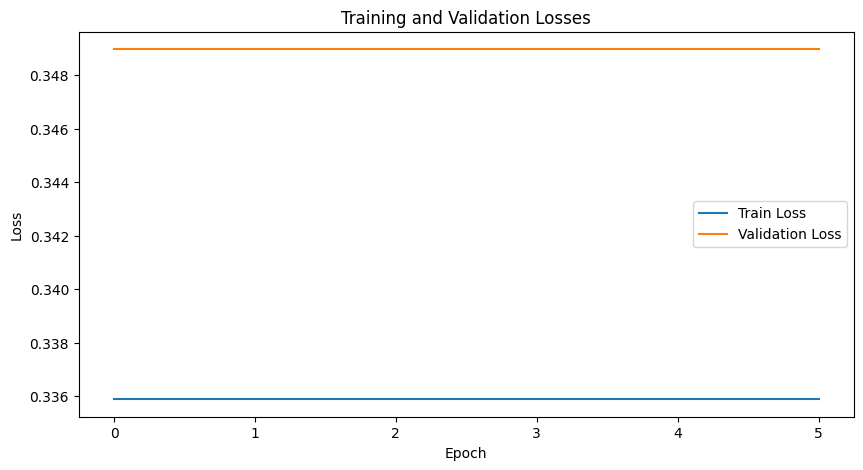

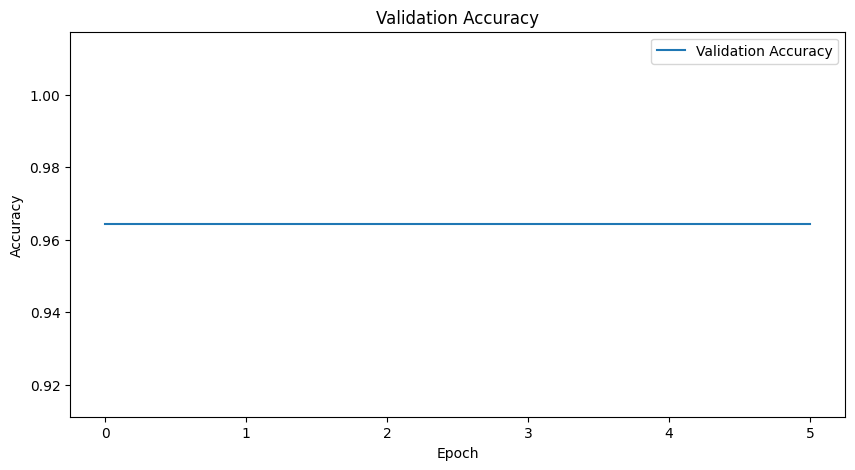

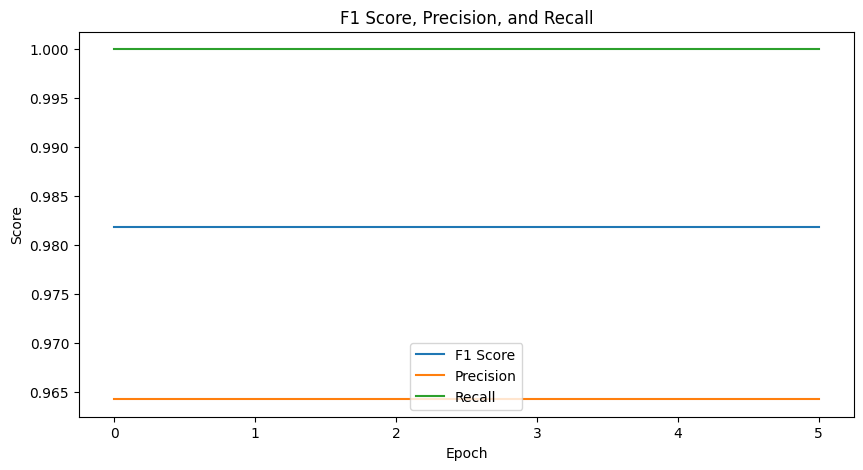

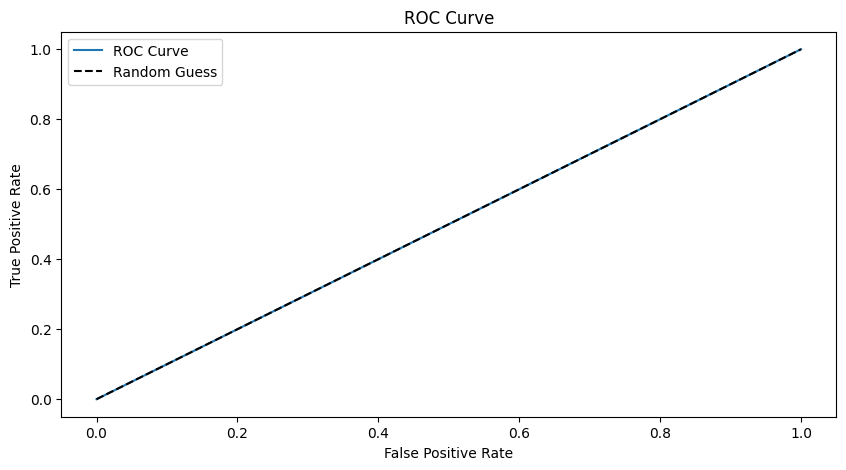

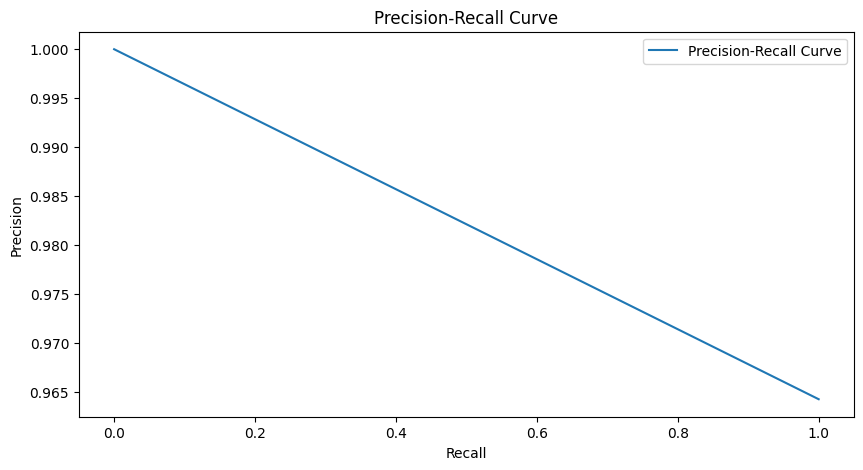

ROC AUC: 0.5000
PR AUC: 0.9643


In [4]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# 학습 함수
def train(model, optimizer, criterion, dataloader, dropout_rate):
    model.train()
    train_loss = 0.0
    y_pred = []
    y_true = []
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
        predicted = (output.squeeze() >= 0.5).float()
        y_pred.extend(predicted.tolist())
        y_true.extend(batch_y.tolist())
    train_loss /= len(dataloader.dataset)
    return train_loss, y_pred, y_true

# 평가 함수
def evaluate(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
            predicted = (output.squeeze() >= 0.5).float()
            y_pred.extend(predicted.tolist())
            y_true.extend(batch_y.tolist())
            correct += (predicted == batch_y).sum().item()
            total += batch_X.size(0)
    val_loss /= len(dataloader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy, y_pred, y_true

# 모델 저장 함수
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

best_val_loss = float('inf')
best_model = None

# 최적의 하이퍼파라미터 로드
with open('MLP/best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

selected_columns = ['OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind', 'revenue1', 'salescost1', 'sga1', 'salary1',
                    'noi1', 'noe1', 'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
                    'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1',
                    'longLoan1', 'netAsset1', 'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
                    'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2',
                    'receivableL2', 'debt2', 'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
                    'employee1', 'employee2', 'ownerChange']
input_dim = len(selected_columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100

# 모델 초기화
model = MLP(input_dim).to(device)
model.load_state_dict(torch.load('best_model.pt'))

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'])
patience = 5
# learning rate scheduler 정의
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)

# Initialize lists for logging
train_losses = []
val_losses = []
val_accuracies = []
f1_scores = []
precisions = []
recalls = []
roc_aucs = []
pr_aucs = []

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    train_loss, train_y_pred, train_y_true = train(model, optimizer, criterion, train_loader, best_params['dropout_rate'])
    val_loss, val_accuracy, val_y_pred, val_y_true = evaluate(model, criterion, val_loader)

    # Log the train and validation loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculate F1 score, precision, recall, ROC AUC, and PR AUC
    f1 = f1_score(val_y_true, val_y_pred)
    precision = precision_score(val_y_true, val_y_pred)
    recall = recall_score(val_y_true, val_y_pred)
    roc_auc = roc_auc_score(val_y_true, val_y_pred)
    pr_auc = average_precision_score(val_y_true, val_y_pred)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)

    # learning rate scheduler 적용
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = model.state_dict()
        save_model(model, 'MLP/best_model.pt')  # 모델 저장
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping!")
            break

    # Print train_loss, val_loss, val_accuracy, f1_score, precision, recall, ROC AUC, and PR AUC
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")

# Log the final results
logging.info("Train Losses: {}".format(train_losses))
logging.info("Validation Losses: {}".format(val_losses))
logging.info("Validation Accuracies: {}".format(val_accuracies))
logging.info("F1 Scores: {}".format(f1_scores))
logging.info("Precisions: {}".format(precisions))
logging.info("Recalls: {}".format(recalls))
logging.info("ROC AUCs: {}".format(roc_aucs))
logging.info("PR AUCs: {}".format(pr_aucs))

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.savefig('MLP/loss_graph.png')  # Save the loss graph as PNG
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('MLP/accuracy_graph.png')  # Save the accuracy graph as PNG
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label='F1 Score')
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('F1 Score, Precision, and Recall')
plt.savefig('MLP/metrics_graph.png')  # Save the metrics graph as PNG
plt.show()

fpr, tpr, _ = roc_curve(val_y_true, val_y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.savefig('MLP/roc_curve.png') # Save the ROC curve as PNG
plt.show()

precision, recall, _ = precision_recall_curve(val_y_true, val_y_pred)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.savefig('MLP/precision_recall_curve.png') # Save the precision-recall curve as PNG
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
import logging
from torch.utils.data import Dataset, DataLoader
import optuna
import logging
# 데이터셋 로드
data = pd.read_csv('data/test.csv')

# 필요한 열 선택
selected_columns = ['OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind', 'revenue1', 'salescost1', 'sga1', 'salary1',
                    'noi1', 'noe1', 'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
                    'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1',
                    'longLoan1', 'netAsset1', 'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
                    'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2',
                    'receivableL2', 'debt2', 'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
                    'employee1', 'employee2', 'ownerChange']

# 데이터 전처리
# - 결측치 처리
data = data.dropna()  # 결측치가 있는 행 제거 또는 다른 방식으로 처리
# - 범주형 데이터 인코딩
categorical_cols = ['OC', 'sido', 'instkind', 'ownerChange']  # 범주형 열을 선택하여 리스트로 작성
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])
# - 수치형 데이터 표준화
numeric_cols = ['sgg', 'openDate', 'bedCount', 'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1', 'interest1',
                'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
                'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1',
                'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2', 'profit2', 'liquidAsset2',
                'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2', 'receivableL2', 'debt2',
                'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2', 'employee1', 'employee2']

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# 특성(X)과 라벨(y) 분리
X = data.drop('OC', axis=1).values
# y = data['OC'].values
y = 'open'

# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor([self.target[idx]])
        return x, y


# 데이터셋과 데이터로더 생성
test_dataset = CustomDataset(X, y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
criterion = nn.BCEWithLogitsLoss()

# 저장된 최적 모델 불러오기
best_model = MLP(input_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

# 테스트 데이터 평가
test_loss, test_accuracy = evaluate(best_model, criterion, test_loader)
logging.info(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)